<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Heat transport

In this project we will discretize and timestep two systems that describe heat transport. In the first part we will timestep a box model for the Earth's surface temperature with heat buffering provided by the deep ocean. In the second part, we will timestep the one-dimensional diffusion equation which can be used to describe heat moving through a medium (e.g. the ground or still air and water).

Through this project, we will learn how to efficiently timestep ordinary and partial differential equations and examine errors introduced by the numerical discretization. We will also have the chance to explore the timescales and physical processes involved in heat transport in the climate system.

## 1. Climate box model

In this part of the project we will timestep the following box model.

$$ C_s \partial_t T = F(t) - \gamma(T-\theta) $$

$$ C_d \partial_t \theta = \gamma (T-\theta) $$

Here, $T(t)$ represents the global mean surface temperature as a function of time and $\theta(t)$ is the temperature of the deep ocean, both expressed as the difference between the temperature and a pre-industrial equilibrium in units of $^\circ K$. The net surface heat flux, $F(t)$, drives departures from the pre-industrial temperatures. The heat flux between the surface and deep ocean is assumed to be proportional to the difference between the surface and deep ocean temperatures. The constants are the heat capacity of the surface of the Earth, $C_s$, the heat capacity of the deep ocean, $C_d$, and the heat flux coefficient, $\gamma$, all given in units of $W/^\circ K/m^2$.

This model is inspired by a more complicated version of a two box climate model in the paper referenced below. (Interested students might consider adding some additional features from their model, but this is not required for this project).

*Nicklas, J.M., Fox-Kemper, B. and Lawrence, C., 2025. Efficient Estimation of Climate State and Its Uncertainty Using Kalman Filtering with Application to Policy Thresholds and Volcanism. Journal of Climate, 38(5), pp.1235-1270.*

Below, we start to build code to solve these equations. Execute the code cells below.  In some cases you will be asked to add code.

Student tasks are in [Section 1.1](#section1pt1), [Section 1.2](#section1pt2), and [Section 1.3](#section1pt3).

In [1]:
# Before we start, import necessary libraries. Run this cell first.
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

Now, let's define values for the various constants. These values are taken from Nicklas et al., 2025.

In [2]:
C_s = 17 # heat capacity of the Earth's surface (W/m^2/K)
C_d = 156 # heat capacity of the deep ocean (W/m^2/K)
gamma = 0.67 # heat exchange coefficient between surface and deep ocean (W/m^2/K)

Now, let's define a function for F(t), the net surface heat flux (in units of $W/m^2$) that will force our model. This function is here to represent the heat imbalance caused by antropogenic greenhouse gases in the atmosphere. When $F=0$, there is no net surface heat flux. The argument, $t$, is the time in years. We will let $t=0$ denote the start of our additional warming, and we set $F=1$ if $t<200$ years and $F=0$ if $t>200$ years. This corresponds to a very bad-case emissions scenario with an abrupt drop in emissions after 200 years.

In [3]:
def F(t):
    return 1 if t < 200 else 0

Next, set the initial conditions. We will use arrays `T` and `theta`. `T[i]` represents the ith value in the array. We will use `T[0]` and `theta[0]` to hold the initial conditions. Subsequent values, `T[2]`, `T[3]`, etc. will be determined by timestepping the equations. We start by initializing the arrays using numpy and filling them with zeros and then set the initial values (this isn't necessary here since our values are zero anyway, but the code is here to that you can change the initial conditions easily)

In [4]:
Nt = 500 # number of time steps (including the starting point)
T = np.zeros(Nt) # surface temperature array
theta = np.zeros(Nt) # deep ocean temperature array
T[0] = 0 # initial surface temperature anomaly (ºK)
theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

Now, create an array with the time (in years) corresponding to each time index. Also, calculate the timestep, `dt`.

In [5]:
t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years

Finally, we are ready to create a for loop to timestep the equations listed at the top of the section.

### 1.1 Student task:
<a id='section1pt1'></a>
Fill in the interior of the for loop to timestep the equations from the start of Section 1 using the Explicit Euler method.

In [6]:
for i in range(0, Nt-1):
    T[i+1] = T[i] + dt * (F(t[i]) - gamma * (T[i] - theta[i])) / C_s
    theta[i+1] = theta[i] + gamma * (dt / C_d) * (T[i] - theta[i])

After you are finished, run the cell below to plot the results

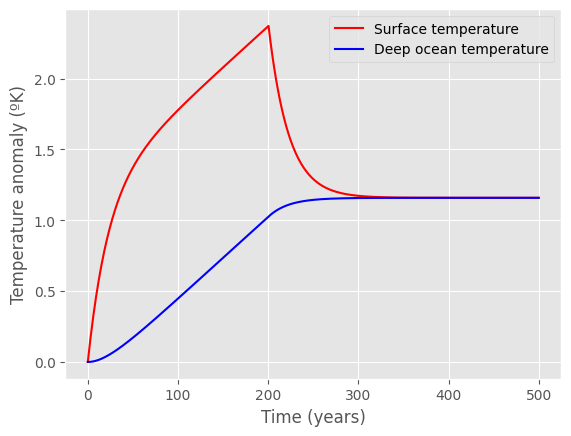

In [7]:
plt.style.use('ggplot')
plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

### 1.2 Student task
<a id='section1pt2'></a>
Discuss the rates of change the temperature of the Earth's surface and the deep ocean at the start of the model run.  Can you explain these rates by defining characteristic timescales from the box model equations?

INSERT DISCUSSION HERE (~1 paragraph)

At the start of the run, when T and theta are still zero, we essentially have:

$
\frac{dT}{dt} = \frac{1}{C_s}
$

$
\frac{d\theta}{dt} = 0
$
, so the surface will warm immediately, whereas the deep ocean warms much slower. This is indeed seen on the figure above.

We can easily find the characteristic timescales, which are approx
C_s/gamma = 25 years for surface and C_d/gamma = 232 years for deep ocean. This confirms that the surface can warm/cool much faster than the deep ocean.

After a while, T gets larger, so dT/dt will slowly decrease, whereas dtheta/dt will slowly increase, until they reach a similar almost linear slope.

When then forcing is taken away, the surface also cools much faster than the deep ocean, until they reach the same temperature.

### 1.3 Student task
<a id='section1pt3'></a>
Modify the forcing function, `F(t)` above with 2-3 scenarios of your choice. Plot the temperature response for each scenario and briefly (2-3 sentences each) describe the temperature responses in each scenario. You will need to replicate some of the code blocks above so that you can produce a new set of plots below.

In [8]:
# Add code to make plots here
def plot_scenario(F):
  Nt = 500 # number of time steps (including the starting point)
  T = np.zeros(Nt) # surface temperature array
  theta = np.zeros(Nt) # deep ocean temperature array
  T[0] = 0 # initial surface temperature anomaly (ºK)
  theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

  t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
  dt = t[1] - t[0] # timestep in years

  for i in range(0, Nt-1):
      T[i+1] = T[i] + dt * (F(i) - gamma * (T[i] - theta[i])) / C_s
      theta[i+1] = theta[i] + gamma * (dt / C_d) * (T[i] - theta[i])

  plt.plot(t,T,'r-')
  plt.plot(t,theta,'b-')
  plt.legend(['Surface temperature','Deep ocean temperature'])
  plt.xlabel('Time (years)')
  plt.ylabel('Temperature anomaly (ºK)')
  plt.show()

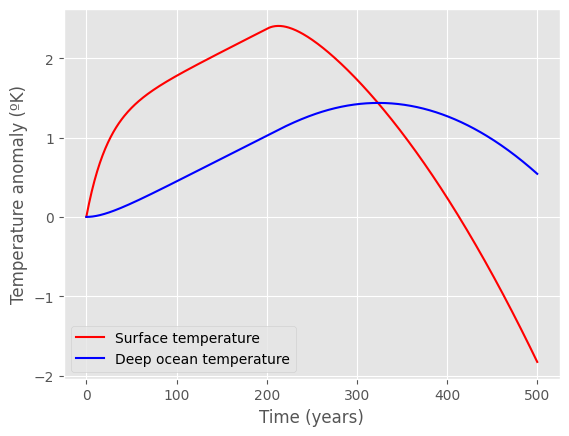

In [9]:
def F1(t):
    if t < 200: # constant positive forcing for 200 years
        return 1
    else:
        return 1 - 0.01*(t-200) # linear decrease in forcing, which becomes negative t=300

plot_scenario(F1)

***Scenario 1: linearly decreasing forcing after 200 years***

As before, both the surface and deep ocean temperatures increase for the first 200 years. Although the forcing starts decreasing linearly after 200 years, the surface temperature still increase a bit further (sort of overshoot). Most interesingly, after 300 years (when forcing becomes zero and then starts decreasing), the deep ocean temperature initially continues to increase a bit (and crosses surface temperature), and then slowly starts decreasing.

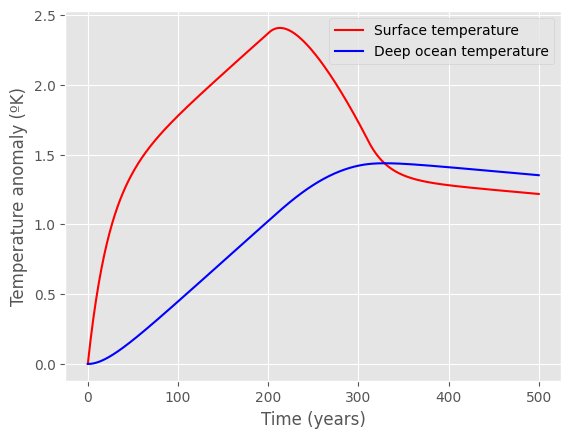

In [10]:
def F2(t):
    if t < 200:
        return 1                # constant positive forcing for 200 years
    elif 200 <= t < 310:
        return 1 - 0.01*(t-200) # rapid linear decrease, crosses zero at t=250, negative after
    else:
      return -0.1

plot_scenario(F2)

***Scenario 2: linearly decreasing forcing after 200 years, with constant negative forcing after 310 years***

This scenario is similar to the one before, but perhaps more realistic, as the forcing is kept at -0.1 after t = 310 years. Interestingly, the deep ocean temperature stays warmer than surface temperature after t = 310 years. So this shows that once the deep ocean has warmed, it is very hard to cool it down again, even when atmospheric CO₂ is strongly reduced.

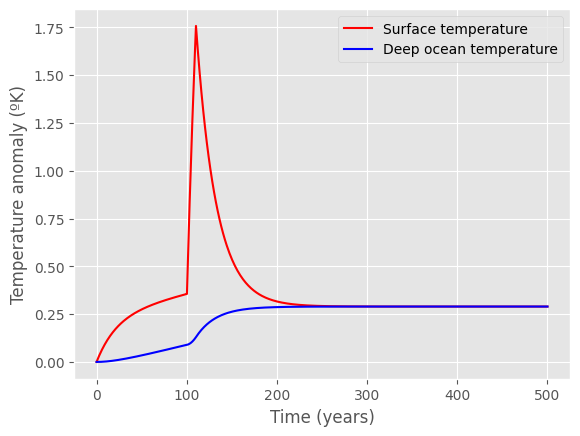

In [11]:
def F3(t):
    if t < 100:
        return 0.2  # mild forcing
    elif t < 110:
        return 3.0  # sudden strong pulse
    else:
        return 0  # returns to mild forcing


plot_scenario(F3)

***Scenario 3: sudden increase in forcing for 10 years followed by zero forcing***

In the first 100 years, temperatures again rise as expected. During the short period of extreme forcing, the surface warms really fast, whereas the deep ocean responds only slightly. Interestingly, after the forcing ends, the surface temperature drops below the value it had at t = 100 years. This is somewhat misleading, as the surface temperature seems to recover, while the deep ocean feels it much more.


## 2. Diffusion equation

In this part of the project we will solve the 1-D diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

We will use second order finite differences to approximate the $x$-derivatives, and we will implement and compare two timestepping methods.

Student tasks are in [Section 2.1](#section2pt1), [Section 2.2](#section2pt2), and [Section 2.3](#section2pt3).

*Mind that error can come from both time derivative or spatial derivative, think of where it comes from*

First, let's discretize the second order derivative using finite differences. The function below builds a coefficient matrix, $M$, so that $Mc$ is a discretized version of $\partial^2_x c$, where in our discretized version $c$ is a column vector.

In [12]:
def construct_M(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
    dx = x[1] - x[0]  # Infer the uniform grid spacing
    Nx = len(x)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
    M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
    return M

Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [13]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler using second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [14]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# crack nicolson using second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [15]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [16]:
# Defining parameters
kappa = 0.021  # diffusivity, original 0.001

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [17]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.13 seconds
Crank-Nicolson method took 0.11 seconds


/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


and finally, plot the results side-by-side

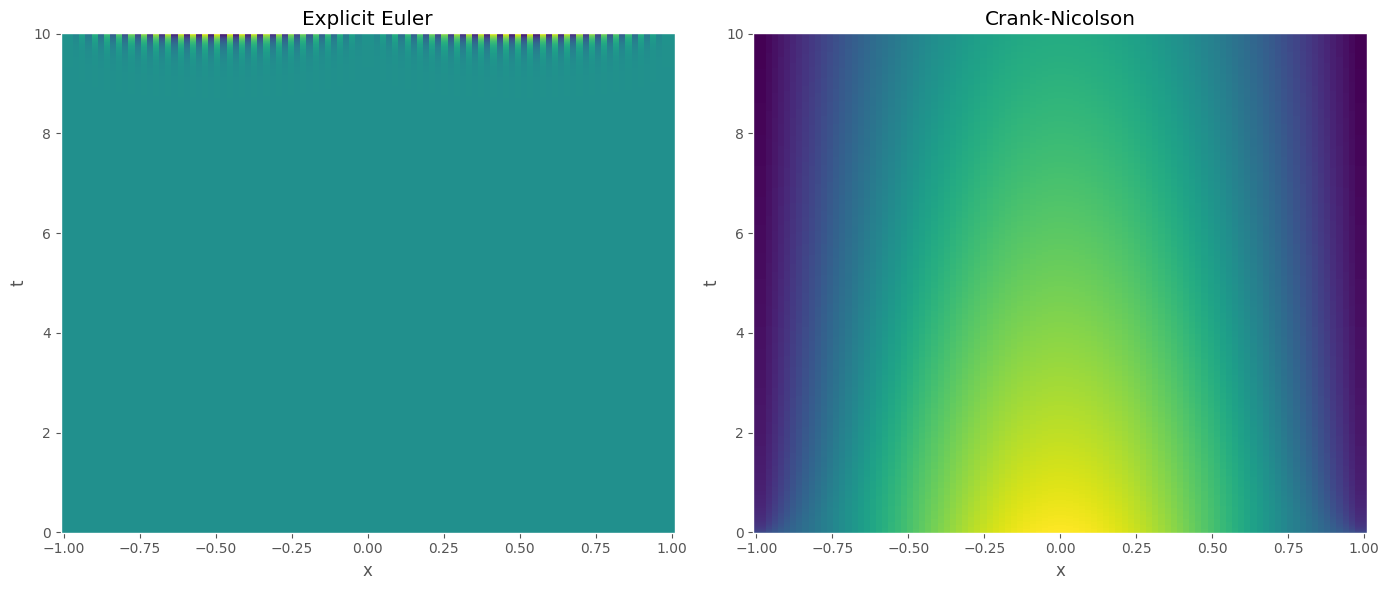

In [18]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have different stability properties. To explore this, try increasing the diffusivity, $\kappa$, and see how each method responds. Discuss your findings below (~2-3 sentences).

When increasing kappa, the Euler method becomes increasingly more diffusive (numerical diffusion) until it blows up, whereas the Crank Nicolson method stays stable (as it is second order in time) for higher kappa. Specifically, the Euler method over-smooths from about kappa = 0.005 (especially clear at kappa = 0.02) and becomes unstable once kappa goes above 0.031.

No already unstable from 0.021 !!

\textbf{Stability criterion for the Explicit Euler method (1-D diffusion):}

Using a von Neumann (Fourier) stability analysis of the forward-time, centered-space (FTCS) scheme,

$
c_i^{n+1} = c_i^n + \kappa \frac{\Delta t}{(\Delta x)^2}
\left( c_{i+1}^n - 2c_i^n + c_{i-1}^n \right),
$

and assuming a Fourier mode solution \( c_i^n = \xi^n e^{i k x_i} \), the amplification factor becomes

$
\xi = 1 - 4r \sin^2\!\left( \frac{k \Delta x}{2} \right),
\quad \text{where} \quad r = \frac{\kappa \Delta t}{(\Delta x)^2}.
$

Requiring \( |\xi| \le 1 \) for all wavenumbers \( k \) gives the stability condition

$
\boxed{ \Delta t \le \frac{(\Delta x)^2}{2\,\kappa} }.
$

In practice, we compute

$
\Delta t_{\text{max}} = \frac{(\Delta x)^2}{2\kappa},
\quad
\Delta t = \frac{t_{\text{end}} - t_{\text{start}}}{N_t},
$

and mark the scheme as \textit{stable} if \( \Delta t \le \Delta t_{\text{max}} \),
otherwise \textit{unstable}. Crank–Nicolson, by contrast, is unconditionally stable.


### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

Explicit Euler method took 0.09 seconds
Crank-Nicolson method took 0.10 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.14 seconds


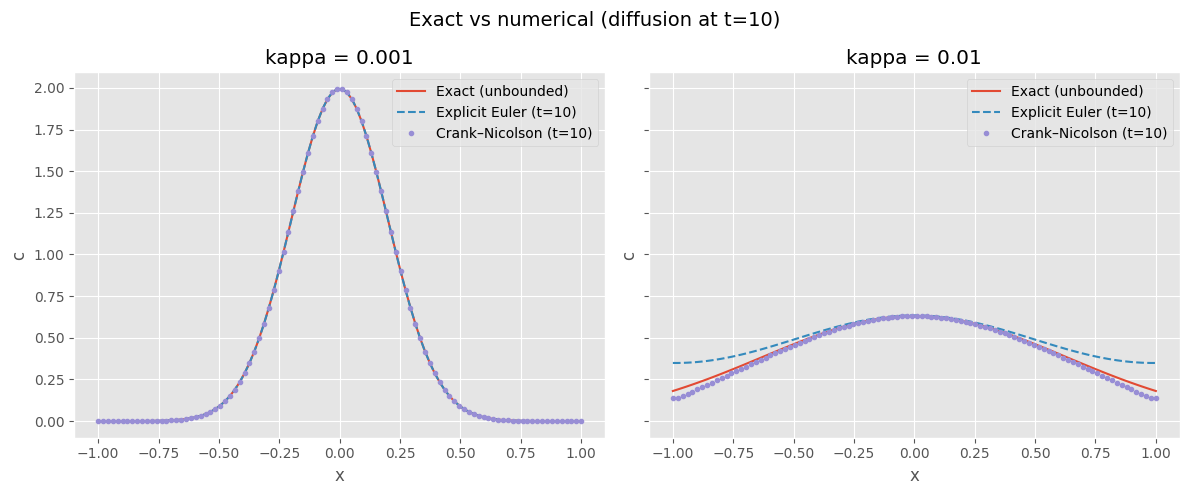

In [19]:
# Add code to plot exact and numerical solutions
kappas = [0.001, 0.01]
t_ic = 10

def exact_solution(x, t, kappa): # define exact solution function
  return (4 * np.pi * kappa * t)**(-0.5) * np.exp(-x**2 / (4 * kappa * t))

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for kappa, ax in zip(kappas, axes):
    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)
    c_exact = exact_solution(x, t_end + t_ic, kappa) # shift time window, as t_ic was 10 for numerical models

    ax.plot(x, c_exact, label="Exact (unbounded)")
    ax.plot(x, c_EE[:, -1], '--', label='Explicit Euler (t=10)')
    ax.plot(x, c_CN[:, -1], '.', label='Crank–Nicolson (t=10)')
    ax.set_xlabel('x')
    ax.set_ylabel('c')
    ax.set_title(f'kappa = {kappa}')
    ax.legend()

fig.suptitle('Exact vs numerical (diffusion at t=10)', fontsize=14)
plt.tight_layout()
plt.show()

For low kappa it is clear that the three curves closely align. However, at larger kappa values, errors start mostly growing at the boundaries (boundary effects come into play).

The difference between the exact solution and the numerical approximation can be quantified by various measures of error. The *local error* is the difference between the exact solution and the numerical approximation after one timestep. The *global error* is the difference between the solutions after a fixed amount of time (which includes the accumulation of multiple steps of local error). A method is first order accurate if the global error is linearly proportional to the timestep. A method is second order accurate if the global error varies quadratically with the timestep. Below, calculate and plot the global error for the Explicit Euler and Crank-Nicolson methods and use your results to infer the order of accuracy of each scheme.

PLOT GLOBAL ERROR FOR EACH SCHEME (1-2 figures) AND DISCUSS ORDER OF ACCURACY (2-3 sentences)

*Here remember that you investigate how decreasing dt affects solution. But here you should know that as long as spatial error is bigger than time one, decreasing dt won't have an effect! So you need to keep that one low as well to actually analyze*

Explicit Euler method took 0.12 seconds
Crank-Nicolson method took 1.12 seconds
Explicit Euler method took 0.26 seconds
Crank-Nicolson method took 1.99 seconds
Explicit Euler method took 0.17 seconds
Crank-Nicolson method took 1.12 seconds
Explicit Euler method took 0.11 seconds
Crank-Nicolson method took 0.99 seconds
Crank-Nicolson method took 0.72 seconds
Crank-Nicolson method took 0.67 seconds
Crank-Nicolson method took 0.86 seconds
Crank-Nicolson method took 0.46 seconds
Crank-Nicolson method took 0.66 seconds


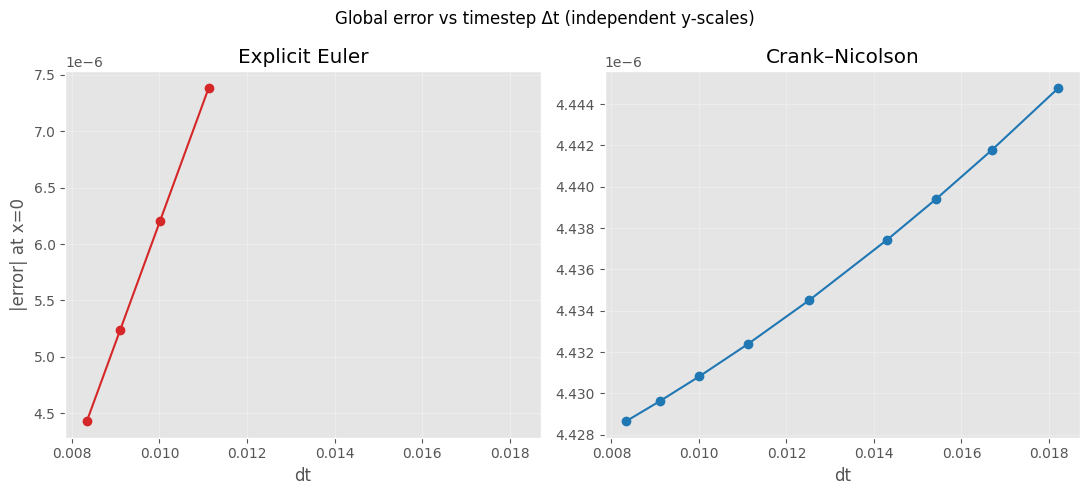

In [20]:
# Add code to plot error here
kappa = 0.001
Nt = [1200, 1100, 1000, 900, 800, 700, 650, 600, 550]
x_start, x_end = -1, 1
Nx = 401
x = np.linspace(x_start, x_end, Nx)
dx = x[1] - x[0]
i0 = 180 # just an example

t_ic = 10
t_start, t_end = 0, 10


dt_list, err_EE, err_CN = [], [], []

for N in Nt:

  t = np.linspace(t_start, t_end, N)
  dt = t[1] - t[0]
  dt_list.append(dt)
  i_t = int(N/10)

# Check Explicit Euler stability
  dt_max = dx**2 / (2 * kappa)

  c_exact = exact_solution(x, t_ic + t[i_t], kappa)

  if dt <= dt_max:
        c_EE = EE(x, t, kappa)
        err_EE.append(abs(c_EE[i0, i_t] - c_exact[i0]))
  else:
      err_EE.append(np.nan)

  c_CN = CN(x, t, kappa)
  err_CN.append(abs(c_CN[i0, i_t] - c_exact[i0]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), sharex=True)

ax1.plot(dt_list, err_EE, 'o-', color='tab:red')
ax1.set_title('Explicit Euler')
ax1.set_xlabel('dt'); ax1.set_ylabel('|error| at x=0')
ax1.grid(True, alpha=0.3)

ax2.plot(dt_list, err_CN, 'o-', color='tab:blue')
ax2.set_title('Crank–Nicolson')
ax2.set_xlabel('dt')
ax2.grid(True, alpha=0.3)


plt.suptitle('Global error vs timestep Δt (independent y-scales)')
plt.tight_layout()
plt.show()



Crank-Nicolson method took 3.12 seconds
Crank-Nicolson method took 1.70 seconds
Crank-Nicolson method took 1.87 seconds
Crank-Nicolson method took 1.44 seconds
Crank-Nicolson method took 1.40 seconds
Crank-Nicolson method took 1.55 seconds
Crank-Nicolson method took 1.11 seconds
Crank-Nicolson method took 1.03 seconds


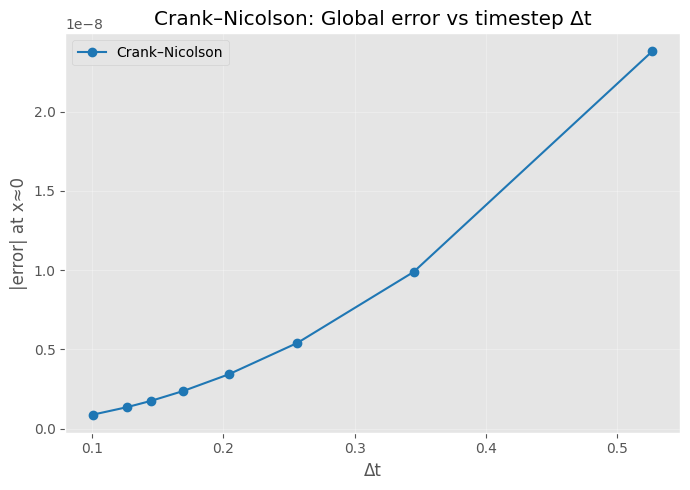

In [21]:
# Add code to plot CN error only
kappa = 0.001
Nt = [100, 80, 70, 60, 50, 40, 30, 20]
x_start, x_end = -1, 1
Nx = 2001
x = np.linspace(x_start, x_end, Nx)
dx = x[1] - x[0]
i0 = 180  # evaluation index (not at boundary)

t_ic = 10
t_start, t_end = 0, 10

dt_list, err_CN = [], []

for N in Nt:
    t = np.linspace(t_start, t_end, N)
    dt = t[1] - t[0]
    dt_list.append(dt)
    i_t = int(N / 10)  # pick time around t ≈ 1

    # Exact and CN
    c_exact = exact_solution(x, t_ic + t[i_t], kappa)
    c_CN = CN(x, t, kappa)
    err_CN.append(abs(c_CN[i0, i_t] - c_exact[i0]))

# --- Plot ---
plt.figure(figsize=(7, 5))
plt.plot(dt_list, err_CN, 'o-', color='tab:blue', label='Crank–Nicolson')
plt.title('Crank–Nicolson: Global error vs timestep Δt')
plt.xlabel('Δt')
plt.ylabel('|error| at x≈0')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()






Say that you also tried looking at x = 0 and averaging over whole x domain. Gave similar results, only for smallest dt tiny bit off the quadratic slope, as more dx error felt.

Crank-Nicolson method took 1.76 seconds
Crank-Nicolson method took 1.53 seconds
Crank-Nicolson method took 1.73 seconds
Crank-Nicolson method took 1.80 seconds
Crank-Nicolson method took 1.34 seconds
Crank-Nicolson method took 1.22 seconds
Crank-Nicolson method took 1.14 seconds
Crank-Nicolson method took 1.06 seconds


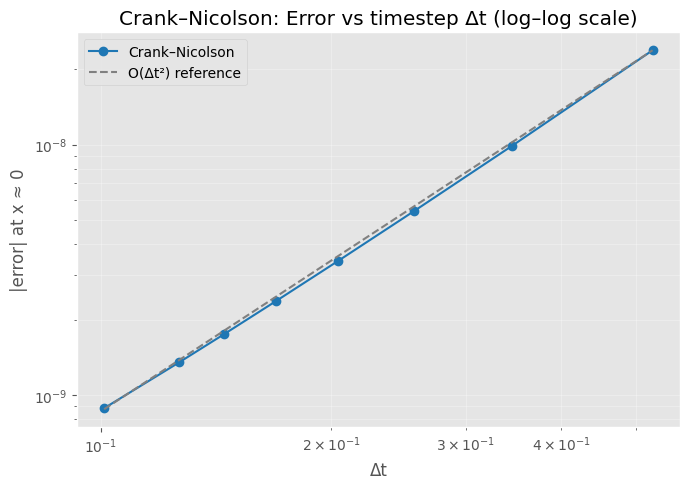

In [22]:
# Add code to plot CN error only (log–log + O(dt^2) reference)
kappa = 0.001
Nt = [100, 80, 70, 60, 50, 40, 30, 20]
x_start, x_end = -1, 1
Nx = 2001
x = np.linspace(x_start, x_end, Nx)
dx = x[1] - x[0]
i0 = 180  # evaluation index (not at boundary)

t_ic = 10
t_start, t_end = 0, 10

dt_list, err_CN = [], []

for N in Nt:
    t = np.linspace(t_start, t_end, N)
    dt = t[1] - t[0]
    dt_list.append(dt)
    i_t = int(N / 10)  # pick time around t ≈ 1

    # Exact and CN
    c_exact = exact_solution(x, t_ic + t[i_t], kappa)
    c_CN = CN(x, t, kappa)
    err_CN.append(abs(c_CN[i0, i_t] - c_exact[i0]))

# --- sort (in case Nt not in descending order) ---
import numpy as np
dt_arr = np.array(dt_list)
err_arr = np.array(err_CN)
order = np.argsort(dt_arr)
dt_arr, err_arr = dt_arr[order], err_arr[order]

# --- Build reference O(dt²) line ---
# normalize so that the reference passes through the smallest dt value
ref_dt = dt_arr[-1]
ref_err = err_arr[-1]
ref_line = ref_err * (dt_arr / ref_dt)**2

# --- Log–log plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.loglog(dt_arr, err_arr, 'o-', color='tab:blue', label='Crank–Nicolson')
plt.loglog(dt_arr, ref_line, '--', color='gray', label='O(Δt²) reference')

plt.title('Crank–Nicolson: Error vs timestep Δt (log–log scale)')
plt.xlabel('Δt')
plt.ylabel('|error| at x ≈ 0')
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Note that these figures don't have the same axes!

**Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.**

Here we shall look at the total error sum over total domain, but with low diffusivity so that boundaries not too much impact idk.
Case 1: cte Nx = 401 as before. Let's take: 6 * 1e-6
Question is mainly: Faster with high dt via Euler or with CN that hase more multiplications but can go much lower

Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.67 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.59 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.51 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.44 seconds
Crank-Nicolson method took 0.37 seconds


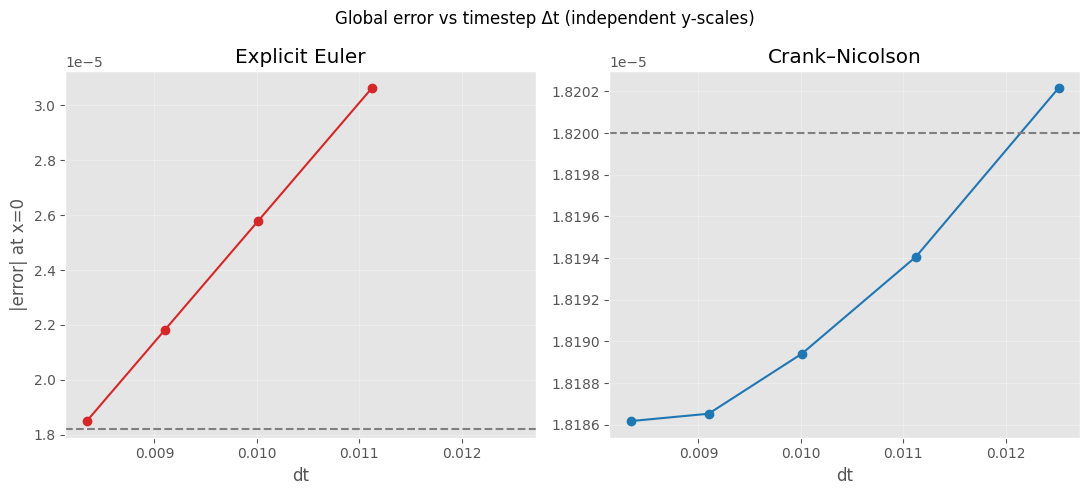

In [23]:
# Add code to plot error here
kappa = 0.001
Nt = [1200, 1100, 1000, 900, 800]
x_start, x_end = -1, 1
Nx = 401
x = np.linspace(x_start, x_end, Nx)
dx = x[1] - x[0]
i0 = 200 # just an example

t_ic = 10
t_start, t_end = 0, 10


dt_list, err_EE, err_CN = [], [], []

for N in Nt:

  t = np.linspace(t_start, t_end, N)
  dt = t[1] - t[0]
  dt_list.append(dt)
  i_t = N-1

# Check Explicit Euler stability
  dt_max = dx**2 / (2 * kappa)

  c_exact = exact_solution(x, t_ic + t[i_t], kappa)

  if dt <= dt_max:
        c_EE = EE(x, t, kappa)
        err_EE.append(np.mean(abs(c_EE[:, i_t] - c_exact)))
  else:
      err_EE.append(np.nan)

  c_CN = CN(x, t, kappa)
  err_CN.append(np.mean(abs(c_CN[:, i_t] - c_exact)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), sharex=True)

ax1.plot(dt_list, err_EE, 'o-', color='tab:red')
ax1.set_title('Explicit Euler')
ax1.set_xlabel('dt'); ax1.set_ylabel('|error| at x=0')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=1.82 * 10**(-5), color='grey', linestyle='--', label='Error tolerance')

ax2.plot(dt_list, err_CN, 'o-', color='tab:blue')
ax2.set_title('Crank–Nicolson')
ax2.set_xlabel('dt')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=1.82 * 10**(-5), color='grey', linestyle='--', label='Error tolerance')

plt.suptitle('Global error vs timestep Δt (independent y-scales)')
plt.tight_layout()
plt.show()

Simpel: kappa = 0.001

Error tolerance = 1*5 1e-5


In [24]:
import time

kappa = 0.001
# eps_tol = 1.5e-5  # target tolerance
eps_tol = 1.722e-06
Nx_list = [101, 201, 401, 801, 1001, 1401]
Nt_list = [10, 20, 40, 80, 100, 200, 400, 650, 800, 1000, 1500, 2000]
EE_best = (0, 0, 0, 0, 0, 10)  # (Nx, Nt, dx, dt, err, runtime)
CN_best = (0, 0, 0, 0, 0, 10)

print(f"Target tolerance: {eps_tol}\n")

for Nx in Nx_list:
    x = np.linspace(-1, 1, Nx)
    dx = x[1] - x[0]
    print(f"\n--- Nx = {Nx}, dx = {dx:.5e} ---")

    for Nt in Nt_list:
        t = np.linspace(t_start, t_end, Nt)
        dt = t[1] - t[0]
        c_exact = exact_solution(x, t_ic + t[-1], kappa)

        # --- Crank–Nicolson ---
        t0 = time.time()
        c_CN = CN(x, t, kappa)
        runtime_CN = time.time() - t0
        err_CN = np.mean(np.abs(c_CN[:, -1] - c_exact))
        print(f"CN  | Nt={Nt:4d}, dt={dt:.3e}, err={err_CN:.3e}, time={runtime_CN:.3f}s", end="")
        if err_CN <= eps_tol:
            print("  ✅ below tol")
            if runtime_CN < CN_best[5]:
                CN_best = (Nx, Nt, dx, dt, err_CN, runtime_CN)
        else:
            print("")

        # --- Explicit Euler ---
        dt_max = dx**2 / (2 * kappa)
        if dt <= dt_max:
            t0 = time.time()
            c_EE = EE(x, t, kappa)
            runtime_EE = time.time() - t0
            err_EE = np.mean(np.abs(c_EE[:, -1] - c_exact))
            print(f"EE  | Nt={Nt:4d}, dt={dt:.3e}, err={err_EE:.3e}, time={runtime_EE:.3f}s", end="")
            if err_EE <= eps_tol:
                print("  ✅ below tol")
                if runtime_EE < EE_best[5]:
                    EE_best = (Nx, Nt, dx, dt, err_EE, runtime_EE)
            else:
                print("")
        else:
            print(f"EE  | Nt={Nt:4d}, dt={dt:.3e}  ⚠️ unstable (dt > dt_max)")

# ---- summary ----
print("\n--- Fastest setups meeting tolerance ---")
if EE_best:
    Nx, Nt, dx, dt, err, runtime = EE_best
    print(f"EE: Nx={Nx}, Nt={Nt}, dx={dx:.3e}, dt={dt:.3e}, err={err:.3e}, time={runtime:.3f}s")
else:
    print("EE: none met tolerance")

if CN_best:
    Nx, Nt, dx, dt, err, runtime = CN_best
    print(f"CN: Nx={Nx}, Nt={Nt}, dx={dx:.3e}, dt={dt:.3e}, err={err:.3e}, time={runtime:.3f}s")
else:
    print("CN: none met tolerance")


Target tolerance: 1.722e-06


--- Nx = 101, dx = 2.00000e-02 ---
Crank-Nicolson method took 0.03 seconds
CN  | Nt=  10, dt=1.111e+00, err=2.075e-04, time=0.030s
EE  | Nt=  10, dt=1.111e+00  ⚠️ unstable (dt > dt_max)
Crank-Nicolson method took 0.03 seconds
CN  | Nt=  20, dt=5.263e-01, err=2.698e-04, time=0.028s
EE  | Nt=  20, dt=5.263e-01  ⚠️ unstable (dt > dt_max)
Crank-Nicolson method took 0.03 seconds
CN  | Nt=  40, dt=2.564e-01, err=2.850e-04, time=0.027s
EE  | Nt=  40, dt=2.564e-01  ⚠️ unstable (dt > dt_max)
Crank-Nicolson method took 0.03 seconds
CN  | Nt=  80, dt=1.266e-01, err=2.886e-04, time=0.030s
Explicit Euler method took 0.00 seconds
EE  | Nt=  80, dt=1.266e-01, err=2.611e-04, time=0.004s
Crank-Nicolson method took 0.03 seconds
CN  | Nt= 100, dt=1.010e-01, err=2.891e-04, time=0.032s
Explicit Euler method took 0.01 seconds
EE  | Nt= 100, dt=1.010e-01, err=1.496e-04, time=0.006s
Crank-Nicolson method took 0.03 seconds
CN  | Nt= 200, dt=5.025e-02, err=2.897e-04, time=0.034s
Ex

--- Fastest setups meeting tolerance target tolerance: 1.5e-05

EE: Nx=401, Nt=1500, dx=5.000e-03, dt=6.671e-03, err=1.123e-05, time=0.085s

CN: Nx=401, Nt=20, dx=5.000e-03, dt=5.263e-01, err=1.339e-05, time=0.123s



INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

### 2.3 Boundary conditions for Crank-Nicolson scheme
<a id='section2pt3'></a>

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This should ensure that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. Plot your results below and verify that the boundary conditions are satisfied.  How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?

In [33]:
def construct_M(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
    dx = x[1] - x[0]  # Infer the uniform grid spacing
    Nx = len(x)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Apply BCs
    M[0, 1] =  2 / dx**2
    M[-1, -2] =  2 / dx**2

    M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
    return M

    print(M.toarray()[:2, :4])


In [34]:
def CN_noforcedBCs(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# crack nicolson using second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        # c[0, k] = c[1, k]
        # c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Crank-Nicolson method took 3.04 seconds


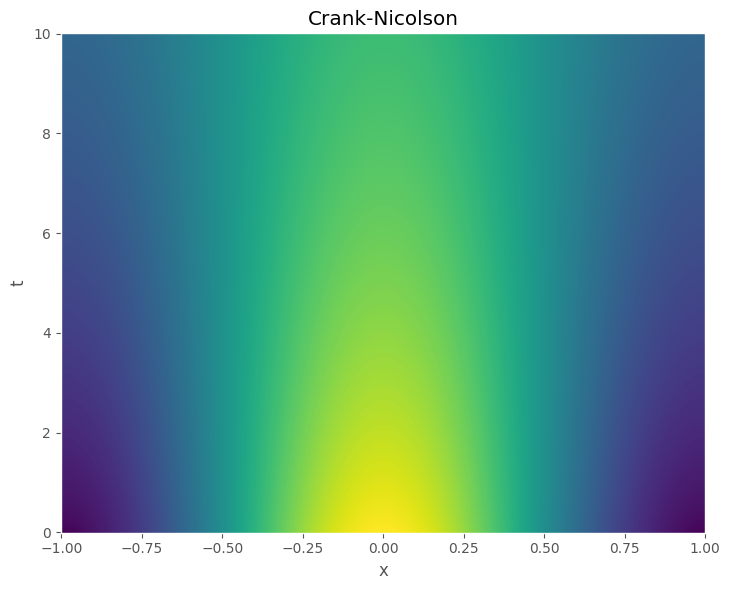

Max difference at left BC: 0.0001741129716797407
Max difference at right BC: 0.0001741129716797407


In [47]:
# Defining parameters
kappa = 0.01  # diffusivity, original 0.001

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 1000

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

c_CN = CN_noforcedBCs(x, t, kappa) # Crank-Nicolson

# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

# verify BCs:
print("Max difference at left BC:", np.max(np.abs(c_CN[0, :] - c_CN[1, :])))
print("Max difference at right BC:", np.max(np.abs(c_CN[-1, :] - c_CN[-2, :])))



/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Crank-Nicolson method took 3.96 seconds


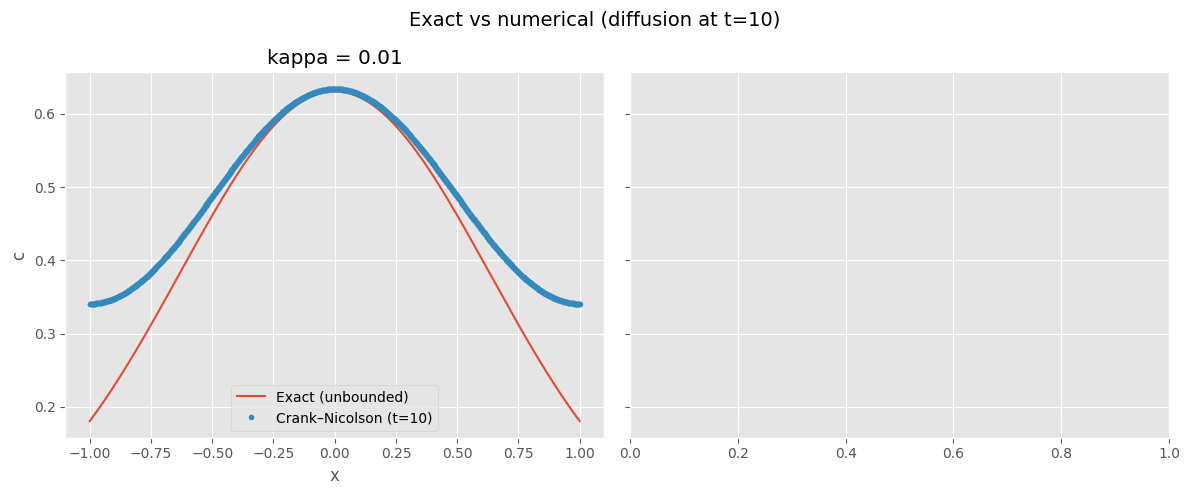

In [48]:
# Add code to plot exact and numerical solutions
kappas = [0.01]
t_ic = 10

def exact_solution(x, t, kappa): # define exact solution function
  return (4 * np.pi * kappa * t)**(-0.5) * np.exp(-x**2 / (4 * kappa * t))

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for kappa, ax in zip(kappas, axes):
    c_CN = CN_noforcedBCs(x, t, kappa)
    c_exact = exact_solution(x, t_end + t_ic, kappa) # shift time window, as t_ic was 10 for numerical models

    ax.plot(x, c_exact, label="Exact (unbounded)")
    ax.plot(x, c_CN[:, -1], '.', label='Crank–Nicolson (t=10)')
    ax.set_xlabel('x')
    ax.set_ylabel('c')
    ax.set_title(f'kappa = {kappa}')
    ax.legend()

fig.suptitle('Exact vs numerical (diffusion at t=10)', fontsize=14)
plt.tight_layout()
plt.show()

ADD DISCUSSION OF DIRICHLET AND NEUMANN BOUNDARY CONDITIONS HERE (NO CODE NEEDED)